# 0. Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch import nn, optim
from torchvision.transforms import transforms
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")

# 1. Data

## 1.1. Real Image Processing

In [2]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

In [3]:
flat_img = 3072

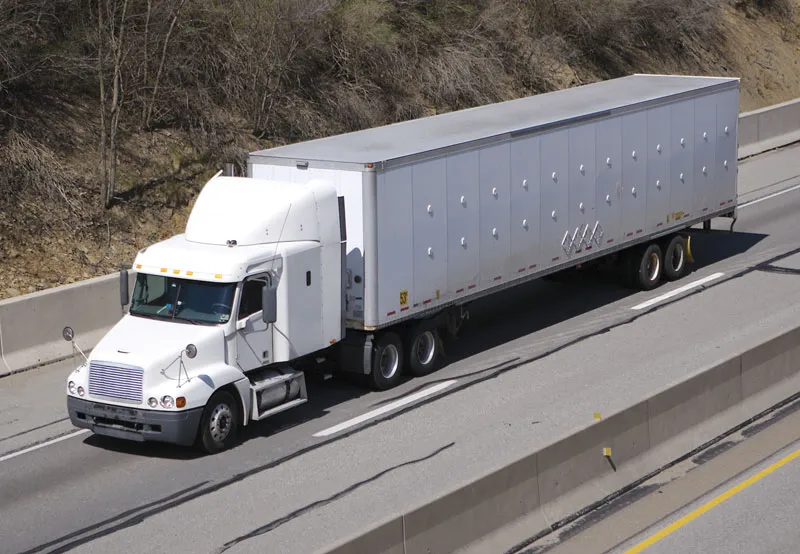

In [4]:
img = Image.open("truck.jpeg")
img

In [5]:
real_img = transform(img)
real_img.shape

torch.Size([3, 32, 32])

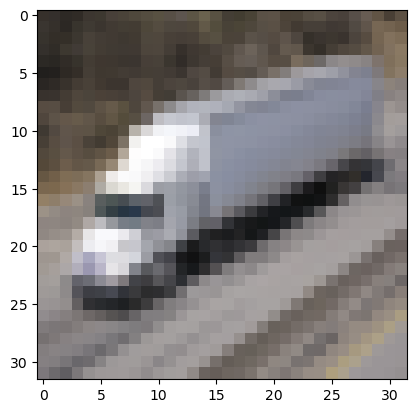

In [6]:
plt.imshow(real_img.permute(1, 2, 0))

## 1.2. Fake Image Processing

In [7]:
torch.manual_seed(2)

fake_img = torch.rand(1, 100)

In [8]:
fake_img.shape

torch.Size([1, 100])

In [9]:
fake_img.size(), fake_img.min(), fake_img.max()

(torch.Size([1, 100]), tensor(0.0021), tensor(0.9809))

# 2. Models

## 2.1. Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(flat_img, 10000), nn.ReLU(), nn.Linear(10000, 1), nn.Sigmoid()
        )

    def forward(self, img):
        img = img.view(1, -1)  # .flatten().unsqueeze(0) is also possible
        out = self.linear(img)

        return out

## 2.2. Generator

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(100, 10000),
            nn.LeakyReLU(),
            nn.Linear(10000, 4000),
            nn.LeakyReLU(),
            nn.Linear(4000, flat_img),
        )

    def forward(self, latent_space):
        latent_space = latent_space.view(
            1, -1
        )  # .flatten().unsqueeze(0) is also possible
        out = self.linear(latent_space)

        return out

# 3. Training

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
discr = Discriminator().to(device)
gen = Generator().to(device)

In [14]:
opt_d = optim.SGD(discr.parameters(), lr=0.001, momentum=0.9)
opt_g = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

criterion = nn.BCELoss()

In [15]:
epochs = 500
discr_e = 20
gen_e = 20

for epoch in tqdm(range(epochs), total=epochs):
    for k in range(discr_e):
        opt_d.zero_grad()

        out_d1 = discr(real_img.to(device))
        loss_d1 = criterion(out_d1, torch.ones((1, 1)).to(device))
        loss_d1.backward()

        out_d2 = gen(fake_img.to(device)).detach()  # Here fake_img is the latent space for generator
        loss_d2 = criterion(discr(out_d2.to(device)), torch.zeros((1, 1)).to(device))
        loss_d2.backward()

        opt_d.step()

    for i in range(gen_e):
        opt_g.zero_grad()

        out_g = gen(fake_img.to(device))
        # loss_g =  criterion(discr(out_g.to(device)), torch.ones(1, 1).to(device))

        # ----Loss function in the GAN paper
        loss_g = 1.0 - (discr(out_g.to(device)))
        loss_g.backward()

        opt_g.step()

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


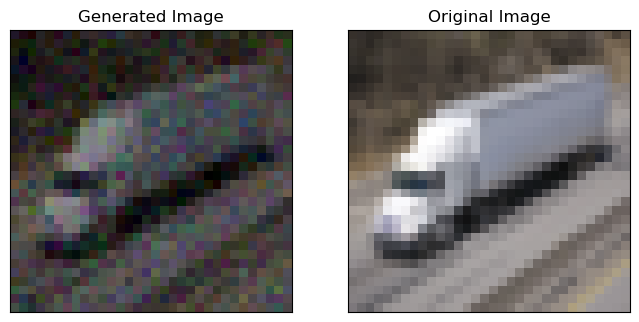

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title("Generated Image")
plt.xticks([])
plt.yticks([])
plt.imshow(out_g.resize(3, 32, 32).permute(1, 2, 0).detach().numpy())

plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(real_img.permute(1, 2, 0).numpy())
plt.show()

In [17]:
torch.save(ge.state_dict(), 'detector_model_weights.pt')
torch.save(detector_model, 'detector_model.pt')

<bound method Module.state_dict of Generator(
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=10000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=10000, out_features=4000, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4000, out_features=3072, bias=True)
  )
)>